In [1]:
#Analsysis of a dense star cluster (globular cluster NGC 104, a.k.a. 47 Tuc) .
#Obtained by the UVIS detector of the Wide Field Camera 3 (WFC3) on the Hubble Space Telescope (Astrophysics & Astronomy programming project)
#David Mathas - October 2023

#imports:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from scipy.optimize import curve_fit


import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

#################
#For me the plots only load with this 'cause of the missing font error (maybe works for you if this is uncommented?):
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [6]:
#functions
def open_fits_file(file_name: str = 'ic2r02050_drz.fits', extension: str = 'SCI'):
    """
    Opens a FITS file and extracts the image data and WCS information from a specified extension.

    Parameters:
                file_name: str: The name of the FITS file to open. Defaults to 'ic2r02050_drz.fits'.
                extension: str: The extension from which to extract the image data and WCS info. Defaults to 'SCI'.

    Returns: tuple: A tuple containing the image data and WCS info from the specified extension of the FITS file.
    """

    #Open fits file:
    fits_file = fits.open(file_name)

    #Access the image data in the 'SCI' extension and WCS info:
    image_data = fits_file[extension].data
    wcs_info = WCS(fits_file[extension].header)
    fits_file.close()
    print("Data read in.")

    return image_data, wcs_info

def plot_cluster_image(image_data: np.ndarray, 
                       vmin: float, 
                       vmax: float, 
                       title: str,
                       sky_coord: bool,
                       wcs_info: astropy.wcs.wcs.WCS):
    """
    Plots an image of a cluster with or without sky coordinates.

    Parameters:
                image_data: np.ndarray: The image data to be plotted.
                vmin: float: The minimum value for the colormap.
                vmax: float: The maximum value for the colormap.
                title: str: The title of the plot.
                sky_coord: bool: If True, the plot will include sky coordinates. If False, it will not.
                wcs_info: astropy.wcs.wcs.WCS: The World Coordinate System information for the image.

    Returns: None. 
    """

    #plot with sky coordinates:
    if sky_coord:
        ax = plt.subplot(projection=wcs_info, label='overlays')
        ax.imshow(image_data, cmap='cividis', vmin = vmin, vmax = vmax)

        ax.coords.grid(True, color='white', ls='solid')
        ax.coords[0].set_axislabel('Right Ascension (J2000)')
        ax.coords[1].set_axislabel('Declination (J2000)')
        ax.set_title(f'{title} with sky coord.', y=1.11)

        overlay = ax.get_coords_overlay('galactic')
        overlay.grid(color='white', ls='dotted')
        overlay[0].set_axislabel('Galactic Longitude')
        overlay[1].set_axislabel('Galactic Latitude')

    #plot without sky coordinates:
    else:
        fig, ax = plt.subplots()
        cax = ax.imshow(image_data, cmap='cividis', vmin=vmin, vmax=vmax)
        fig.colorbar(cax)
        ax.set_xlabel('Right Ascension (J2000)')
        ax.set_ylabel('Declination (J2000)')
        ax.set_title(title)

    plt.show()

def clean_fits_image(raw_fits_image):
    """
    Preprocesses a FITS image by masking NaN values, calculating statistics,
    and subtracting the median from the image.

    Parameters:
    raw_fits_image: np.ndarray: The original FITS image data.

    Returns:
    np.ma.MaskedArray: The preprocessed image with NaN values masked and the median subtracted.
    dict: A dictionary containing image statistics (mean, median, std).
    """

    #mask nans:
    masked_img = np.ma.masked_invalid(raw_fits_image)

    #calc median and subtract from img
    mean, median, std = sigma_clipped_stats(masked_img)
    stats = {'mean': mean, 'median': median, 'std': std}
    print('The image stats are:', stats)
    background_subtracted = masked_img - median
    background_subtracted = np.nan_to_num(background_subtracted)

    return background_subtracted, stats

def star_detection(cleaned_image_dataset: np.ma.core.MaskedArray, 
                   fwhm: float = 3.0, 
                   threshold_scale: float = 2.5):
    """
    Detects stars in a cleaned image dataset and returns their positions and properties.

    Parameters:
    cleaned_image_dataset: np.ma.MaskedArray: The preprocessed image dataset with NaN values masked.
    fwhm: float: The full width at half maximum (FWHM).
    threshold_scale: float: The scale factor to multiply with the standard deviation to set the detection threshold.

    Returns:
    astropy.photutils.aperture.CircularAperture: Aperture objects representing the positions of detected stars directly for plotting.
    np.ndarray: X-coordinates of detected stars, separately for further processing.
    np.ndarray: Y-coordinates of detected stars, separately for further processing.
    """

    _, _, std = sigma_clipped_stats(cleaned_image_dataset) #obtain standard deviation

    #star detection:
    starfinder = DAOStarFinder(threshold = threshold_scale * std, fwhm = fwhm)
    sources_table = starfinder(cleaned_image_dataset)
    for col in sources_table.colnames:
        if col not in ('id'):
            sources_table[col].info.format = '%.2f'

    nr_stars_found = len(sources_table) #number of stars
    print('Number of stars found:', nr_stars_found, '\n')
    print('--------- Table: ---------')
    sources_table.pprint(max_width = 500)

    #obtain starfinder-located positions:
    positions = np.transpose((sources_table['xcentroid'], sources_table['ycentroid']))
    locations = CircularAperture(positions, r = 4.5)

    return locations, sources_table['xcentroid'], sources_table['ycentroid']



def plot_stars(cleaned_subset: np.ndarray, vmin: float, vmax: float, locations: pd.DataFrame, title: str):
    """
    Function to plot the cluster star data and their found locations. 
    It uses the LogNorm function to normalize the data.

    Parameters:
    cleaned_subset: np.ndarray: The cleaned subset of data.
    vmin: float: The minimum value for normalization.
    vmax: float: The maximum value for normalization.
    locations: pd.DataFrame: The locations of the subset.
    title:str: The title for the plot.
    """

    fig, ax = plt.subplots()
    ax.imshow(cleaned_subset, norm = LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{title} with {len(locations)} located stars')
    locations.plot(color = 'red', lw = 1.5, alpha = 0.6)
    plt.show()


def gaussian_with_background(x: np.ndarray,
                             amplitude: float,
                             mean: float,
                             stddev: float,
                             background: float) -> np.ndarray:
    """
    One-dimensional Gaussian function with a background term.

    Parameters:
    x: np.ndarray: The independent variable (e.g., x-coordinates).
    amplitude: float: Amplitude of the Gaussian peak.
    mean: float: Mean (center) of the Gaussian.
    stddev: float: Standard deviation (width) of the Gaussian.
    background: float: Constant background level.

    Returns:
    numpy.ndarray: The values of the Gaussian with background at the given x values.
    """

    gaussian = amplitude * np.exp(-((x - mean) / (2 * stddev))**2)
    #Add the background term
    result = gaussian + background

    return result


def cluster_center_analysis(data_star_x: astropy.table.column.Column, 
                            data_star_y: astropy.table.column.Column, 
                            clean_image_data: np.ma.core.MaskedArray,
                            skip_bins: int = 4) -> np.ndarray:
    """
    Analyzes the center of a star cluster by fitting a Gaussian function to the histogram of star positions.

    Parameters:
    data_star_x: astropy.table.column.Column: The x-positions of the stars.
    data_star_y: astropy.table.column.Column: The y-positions of the stars.
    skip_bins: int: The number of bins to skip at the beginning and end of the histogram when fitting the Gaussian function.

    Returns: np.ndarray: A list containing the bin centers and fitted parameters for both x and y positions.
    """

    #histograms for x-positions and y-positions
    x_hist, x_bins = np.histogram(data_star_x, bins=100)
    y_hist, y_bins = np.histogram(data_star_y, bins=100)

    #bin centers for x and y histograms:
    x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2

    #Initial parameter estimates
    initial_params_x = [max(x_hist), np.mean(x_bin_centers), np.std(x_bin_centers), np.mean(clean_image_data)]
    initial_params_y = [max(y_hist), np.mean(y_bin_centers), np.std(y_bin_centers), np.mean(clean_image_data)]

    #fit the data:
    x_params, x_covariance = curve_fit(gaussian_with_background, x_bin_centers[skip_bins:-skip_bins], x_hist[skip_bins:-skip_bins], p0=initial_params_x)
    y_params, y_covariance = curve_fit(gaussian_with_background, y_bin_centers[skip_bins:-skip_bins], y_hist[skip_bins:-skip_bins], p0=initial_params_y)

    return [x_bin_centers, y_bin_centers, x_params, y_params]


def plot_cluster_center(data_star_x: astropy.table.column.Column, 
                        data_star_y: astropy.table.column.Column,
                        x_bin_centers: np.ndarray, 
                        y_bin_centers: np.ndarray, 
                        x_params: np.ndarray, 
                        y_params: np.ndarray, 
                        vmin: float,
                        vmax: float) -> None:
    """
    Plots the histograms of star positions with fitted functions and a plot of the globular cluster with approximate cluster center.

    Parameters:
    data_star_x: astropy.table.column.Column: The x-positions of the stars.
    data_star_y: astropy.table.column.Column: The y-positions of the stars.
    x_bin_centers: np.ndarray: The bin centers for the histogram of x-positions.
    y_bin_centers: np.ndarray: The bin centers for the histogram of y-positions.
    x_params: np.ndarray: The fitted parameters for the Gaussian function for x-positions.
    y_params: np.ndarray: The fitted parameters for the Gaussian function for y-positions.

    Returns: None
    """

    #Plots:
    print('--------- Plot of histograms with fitted functions: ---------')
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(data_star_x, bins=100, color='grey', alpha=0.7)
    plt.plot(x_bin_centers, gaussian_with_background(x_bin_centers, *x_params), 'r-', label='Fit')
    plt.xlabel('X-Position')
    plt.ylabel('Frequency')
    plt.grid(linestyle = '--', color = 'grey')
    plt.title('Histogram of X-Positions')

    plt.subplot(1, 2, 2)
    plt.hist(data_star_y, bins=100, color='k', alpha=0.7)
    plt.plot(y_bin_centers, gaussian_with_background(y_bin_centers, *y_params), 'r-', label='Fit')
    plt.xlabel('Y-Position')
    plt.xlabel('Y-Position')
    plt.ylabel('Frequency')
    plt.grid(linestyle = '--')
    plt.title('Histogram of Y-Positions')

    plt.tight_layout()
    plt.show()

    #Plot with cluster center:
    print('--------- Plot of of Globular Cluster with approximate cluster center: ---------')
    # Create figure and axes objects
    fig, ax = plt.subplots()
    im = ax.imshow(CLEAN_IMAGE_DATA, cmap='Greys', vmin=vmin, vmax=vmax)

    #Add circle to plot:
    x_center_cluster = x_params[1]
    y_center_cluster = y_params[1]
    circle = Circle((x_center_cluster, y_center_cluster), radius=60, fill=False, edgecolor='red')
    ax.add_patch(circle)
    plt.colorbar(im)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Globular Cluster NGC 104 - Cleaned Data with approximate cluster center')
    plt.show()

def stellar_dens(x_center: float, y_center: float, x_positions: np.ndarray, y_positions: np.ndarray):
    """
    Calculate the stellar density profile of the cluster.

    Parameters:
    x_center: float: x-coordinate of the cluster center.
    y_center: float: y-coordinate of the cluster center.
    x_positions: np.ndarray: Array of x-positions of detected stars.
    y_positions: np.ndarray: Array of y-positions of detected stars.

    Returns:
    hist_radii: np.ndarray: Histogram of pixel radii from the cluster center.
    stellar_density: np.ndarray: Stellar density values in stars per square arcsec.
    error_bars: np.ndarray: Estimated error bars for the stellar density values.
    """

    #pixel radii histogram:
    pixel_radii = ((x_positions - x_center)**2 + (y_positions - y_center)**2)**.5 #euclidian distance
    pixe_arcsec_convs = 0.04
    arcsecond_radii = pixel_radii * pixe_arcsec_convs
    hist_radii, bin_edges = np.histogram(arcsecond_radii, bins = 'sqrt', range=(0, 2000 * pixe_arcsec_convs)) #maximum radius limit < 2000 pixels

    #divide hist values per bin by bin area:
    annulus_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2) #area = pi * (outer^2 - inner^2)
    #division to get stellar density:
    stellar_density = hist_radii / annulus_areas

    #calculate bin centers:
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    #estimate error bars:
    error_bars = np.sqrt(hist_radii) / annulus_areas 

    return bin_centers, stellar_density, error_bars


def plot_stellar_density(bin_centers: np.ndarray, stellar_dens: np.ndarray, errors: np.ndarray) -> None:
    """Plots the stellar density as a function of radius in a log-log scale.

    Parameters:
    bin_centers: np.ndarray: The bin centers for the histogram. Represents the midpoints of each bin.
    stellar_dens: np.ndarray: The stellar density data. Represents the frequency or count of stars that fall within each bin.
    errors: np.ndarray: The errors associated with the stellar density data.

    Returns:None
    """

    plt.figure(figsize=(8, 4))
    plt.errorbar(bin_centers, stellar_dens, 
                 yerr = errors, xerr = 0.1,
                 fmt = 'o', markersize = 4, capsize=4, 
                 label = 'Stellar Density', color = 'k')
    plt.title('Stellar Density vs. Radius (log-log scale)')
    plt.xlabel('Distance (arcsec)')
    plt.ylabel('Stellar Density (stars per square arcsec)')
    plt.xscale('log') #log scale axes
    plt.xlim(right=10**2.2)
    plt.ylim(bottom=10**0)
    plt.yscale('log')
    plt.grid(True, linestyle = '--')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def king_model(r: float,
               n_0: float,  
               a: float, 
               gamma: float) -> float:
    """
    King model profile for stellar density.
    
    Parameters:
    r: float: Radius
    n_0: float: Normalization at zero radius
    a: float: Radial scale-length
    gamma: float: Power-law index
    
    Returns:
    Stellar density at radius r as float.
    """

    return n_0 * (1 + (r / a)**2) ** (-gamma / 2)

def calc_core_radius(a: float, gamma: float) -> float:
    """
    Calculate the core radius of a cluster using the King model parameters.

    Parameters:
    a: float: The radial scale-length in the King model.
    gamma: float: The power-law index in the King model.

    Returns: float: The core radius of the cluster in the same units as 'a'.
    """

    return a * (2 ** (2 / gamma) - 1) ** 0.5

def fit_and_plot(bin_centers_data: np.ndarray, 
                 stellar_dens_data: np.ndarray, 
                 errors_data: np.ndarray, 
                 king_model: callable) -> None:
    """
    Fits the King model to the data and plots the stellar density as a function of radius in a log-log scale.

    Parameters:
    bin_centers_data: np.ndarray: The bin centers for the histogram. Represents the midpoints of each bin.
    stellar_dens_data: np.ndarray: The stellar density data. Represents the frequency or count of stars that fall within each bin.
    errors_data: np.ndarray: The errors associated with the stellar density data.
    king_model: callable: The King model function to fit to the data.

    Returns: None
    """

    #init guesses:
    n_0_guess = 8
    a_guess = 20
    gamma_guess = 10
    p0 = [n_0_guess, a_guess, gamma_guess]

    #fitfunction to the data:
    popt, pcov = curve_fit(king_model, bin_centers_data, stellar_dens_data, p0=p0, sigma=errors_data)

    n0_fit, a_fit, gamma_fit = popt
    print('n0_fit:', n0_fit)
    print('a_fit:', a_fit)
    print('gamma_fit:', gamma_fit)

    #plot stellar density with errors vs. radius:
    plt.figure(figsize=(8, 4))
    plt.errorbar(bin_centers_data, stellar_dens_data, 
                 yerr = errors_data, xerr = 0.1,
                 fmt = 'o', markersize = 4, capsize=4, 
                 label = 'Stellar Density', color = 'k')
    plt.plot(bin_centers_data, king_model(bin_centers_data, *popt), 
             label='Fit', 
             color='r', 
             linewidth=2)
    plt.title('Stellar Density vs. Radius (log-log scale) with best fit.')
    plt.xlabel('Distance (arcsec)')
    plt.ylabel('Stellar Density (stars per square arcsec)')
    plt.xscale('log') #log scale axes
    plt.xlim(right=10**2.2)
    plt.ylim(bottom=10**0)
    plt.yscale('log')
    plt.grid(True, linestyle = '--')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    print(f'The core radius is: {np.round(calc_core_radius(a_fit, gamma_fit), 2)} arcsec')



Data read in.


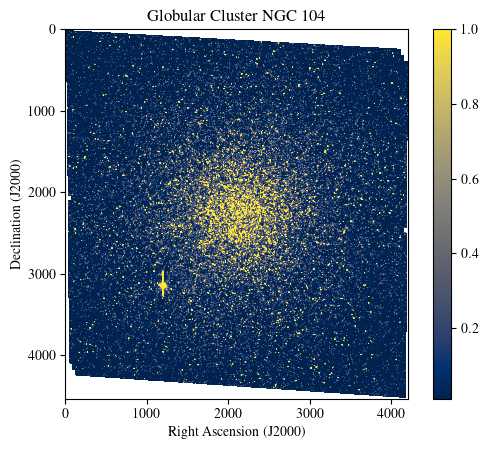

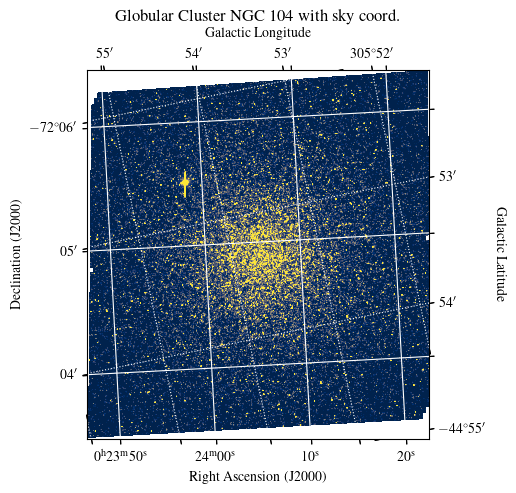

---------- Subset plot: ----------


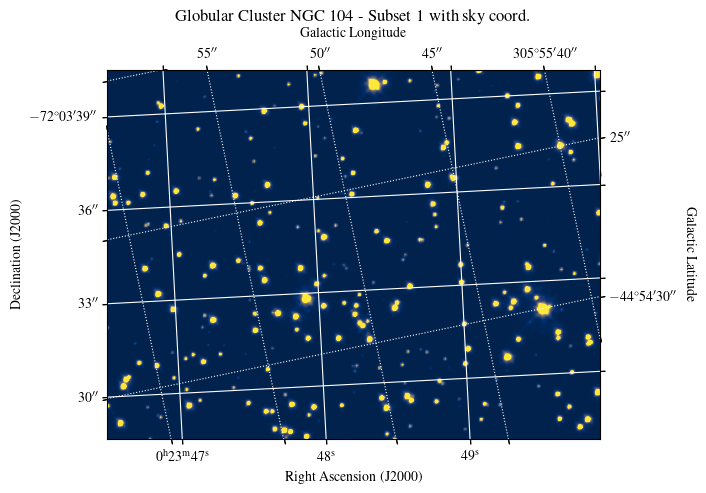

The image stats are: {'mean': 0.006639845, 'median': -0.0035947529, 'std': 0.028089672}
The image stats are: {'mean': -0.01006022, 'median': -0.012973782, 'std': 0.010036564}
---------- Cleaned subset plot: ----------


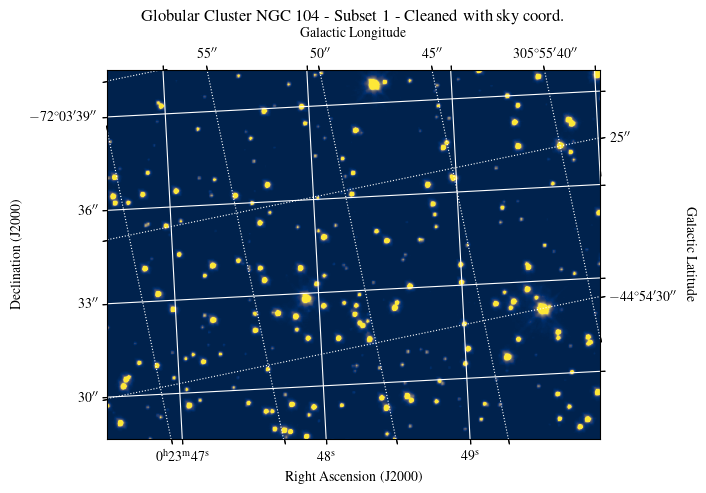

---------- Stars in subset: ----------
Number of stars found: 312 

--------- Table: ---------
 id xcentroid ycentroid sharpness roundness1 roundness2  npix sky   peak   flux   mag 
--- --------- --------- --------- ---------- ---------- ----- ---- ----- ------- -----
  1     34.50      0.18      0.83      -0.52      -0.60 25.00 0.00  0.57   17.65 -3.12
  2    232.71      0.25      0.83      -0.36      -0.46 25.00 0.00  1.32   40.98 -4.03
  3    144.95      1.27      0.62       0.61      -0.05 25.00 0.00  0.67   21.16 -3.31
  4    161.56      1.59      0.56       0.51      -0.00 25.00 0.00  6.53  227.79 -5.89
  5    226.85      3.62      0.62       0.28       0.11 25.00 0.00  1.92   65.24 -4.54
  6    148.38      5.51      0.51      -0.22      -0.05 25.00 0.00  3.82  133.01 -5.31
  7    143.42      6.56      0.58      -0.25       0.03 25.00 0.00 10.04  341.58 -6.33
  8    135.82      7.62      0.60       0.28       0.08 25.00 0.00  4.57  156.45 -5.49
  9    290.17      7.59      0.60  

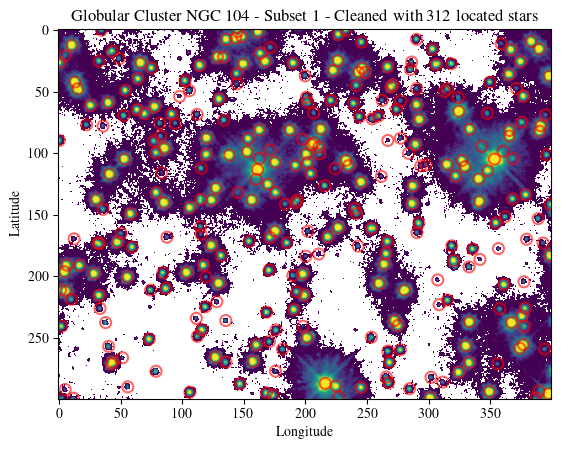

---------- Stars in entire dataset: ----------
Number of stars found: 64634 

--------- Table: ---------
  id  xcentroid ycentroid sharpness roundness1 roundness2  npix sky   peak  flux   mag 
----- --------- --------- --------- ---------- ---------- ----- ---- ----- ------ -----
    1     54.31      2.94      0.64       0.21      -0.58 25.00 0.00  2.98  35.37 -3.87
    2    102.49      5.25      0.63       0.05      -0.22 25.00 0.00  0.27   3.90 -1.48
    3    142.91      7.76      0.66       0.40      -0.07 25.00 0.00  0.30   3.44 -1.34
    4    178.94     12.55      0.69       0.13       0.22 25.00 0.00  2.82  32.11 -3.77
    5    120.57     17.56      0.51      -0.43       0.11 25.00 0.00  0.16   2.11 -0.81
    6    378.87     21.22      0.85      -0.41      -0.52 25.00 0.00  0.82   8.79 -2.36
    7    194.61     23.33      0.57      -0.13       0.05 25.00 0.00 10.84 133.88 -5.32
    8    102.67     24.90      0.58       0.21      -0.04 25.00 0.00  0.21   2.74 -1.10
    9    311.73

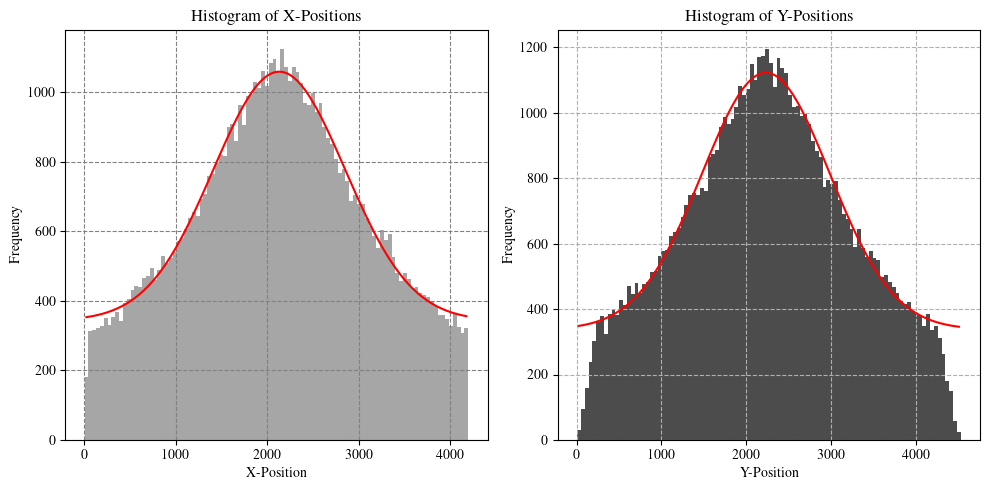

--------- Plot of of Globular Cluster with approximate cluster center: ---------


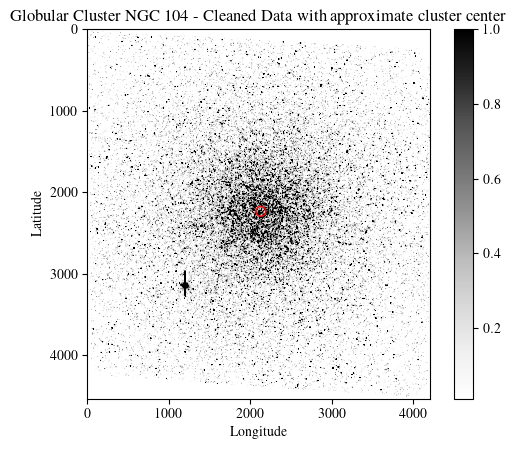

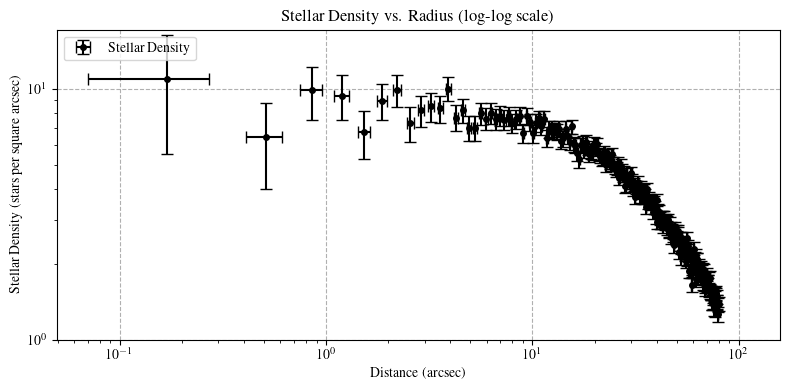

n0_fit: 7.952269874006934
a_fit: 26.591167394844167
gamma_fit: 1.5112986723050408


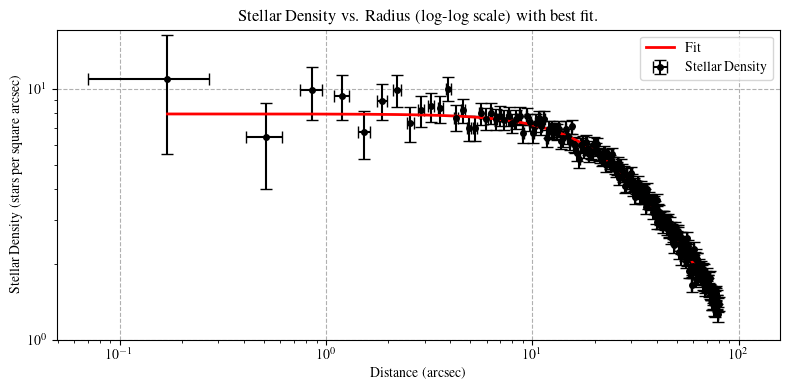

The core radius is: 32.59 arcsec


In [7]:
#Main():

#1.
#Load in data:
IMAGE_DATA, WCS_INFO = open_fits_file()

#image plot raw no coordinates
VMIN = 0.01 #Min pixel value 
VMAX = 1 #Max pixel value
plot_cluster_image(IMAGE_DATA, 
                   VMIN, 
                   VMAX, 
                   'Globular Cluster NGC 104', 
                   0,
                   WCS_INFO)
#with coordinates
plot_cluster_image(IMAGE_DATA, 
                   VMIN, 
                   VMAX, 
                   'Globular Cluster NGC 104', 
                   1,
                   WCS_INFO)

#2.
#look at a subset of the image:
SUBSET_1 = IMAGE_DATA[4000:4300, 1700:2100]
print("---------- Subset plot: ----------")
plot_cluster_image(SUBSET_1, 
                   VMIN, 
                   VMAX, 
                   'Globular Cluster NGC 104 - Subset 1', 
                   1,
                   WCS_INFO)

#Clean the data:
CLEAN_IMAGE_DATA, IMAGE_STATS = clean_fits_image(IMAGE_DATA) #obtain cleaned full image dataset

#plot cleaned image of subset:
CLEANED_SUBSET_1, _ = clean_fits_image(SUBSET_1)
print("---------- Cleaned subset plot: ----------")
plot_cluster_image(SUBSET_1, 
                   VMIN, 
                   VMAX, 
                   'Globular Cluster NGC 104 - Subset 1 - Cleaned', 
                   1,
                   WCS_INFO)

#3. & #4.
#Star detection:
print("---------- Stars in subset: ----------")
SUBSET_1_LOCATIONS, _, _ = star_detection(CLEANED_SUBSET_1)
plot_stars(CLEANED_SUBSET_1, VMIN, VMAX, SUBSET_1_LOCATIONS, 'Globular Cluster NGC 104 - Subset 1 - Cleaned')

#obtain info about entire dataset:
print("---------- Stars in entire dataset: ----------")
DATA_STAR_LOCATIONS, DATA_STAR_X, DATA_STAR_Y = star_detection(CLEAN_IMAGE_DATA)

#Fit and plot of cluster center:
X_BIN_CENTERS, Y_BIN_CENTERS, X_PARAMS, Y_PARAMS =  cluster_center_analysis(DATA_STAR_X, DATA_STAR_Y, CLEAN_IMAGE_DATA)
plot_cluster_center(DATA_STAR_X, DATA_STAR_Y, X_BIN_CENTERS, Y_BIN_CENTERS, X_PARAMS, Y_PARAMS, VMIN, VMAX)

#5. 
#Stellar density plot:
BIN_CENTERS_DATA, STELLAR_DENS_DATA, ERRORS_DATA = stellar_dens(X_PARAMS[1], Y_PARAMS[1], DATA_STAR_X, DATA_STAR_Y)
plot_stellar_density(BIN_CENTERS_DATA, STELLAR_DENS_DATA, ERRORS_DATA)

#6. 
#Fit king model and plot:
fit_and_plot(BIN_CENTERS_DATA, STELLAR_DENS_DATA, ERRORS_DATA, king_model)

